## Import Libraries

In [2]:
import matplotlib.pyplot as plt
import torch

#load dataset
from datasets import load_dataset

#llama2
from transformers import LlamaForCausalLM, LlamaTokenizer


#profiler
from transformers import TrainerCallback
from contextlib import nullcontext

# training
from transformers import default_data_collator, Trainer, TrainingArguments, DataCollatorForLanguageModeling

#lora
from peft import get_peft_model, LoraConfig, TaskType

False
'CUDASetup' object has no attribute 'cuda_available'


/users/p/s/psuchdev/miniconda3/envs/llama_env/lib/python3.9/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


## Load Dataset

In [3]:
dataset = load_dataset("parisachdev/train", data_files='manifold_annotated.json', split='train')
train_dataset = dataset.train_test_split(test_size=0.09, shuffle=True, seed=42)


In [4]:
train_dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'output', 'input'],
        num_rows: 193
    })
    test: Dataset({
        features: ['id', 'output', 'input'],
        num_rows: 20
    })
})

## Initialize model (Llama 2)

In [5]:
model_id = "/users/p/s/psuchdev/LLM/models/huggingface/13Bf"
output_dir = "tmp/llama-output"

model = LlamaForCausalLM.from_pretrained(model_id, device_map='auto')  # Automatically assigns the model to the best device (gpu)
tokenizer = LlamaTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token  # set pad token to be the end of sequence token

Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

## Format Dataset

In [7]:
sys_prompt = """
Pretend you are a philosopher analyzing comments to determine if they express a belief. Define 'belief' as the mental attitude where something is regarded as true, without needing active reflection or evidence.
For each statement, ask:
1. Does this imply the subject regards something as true?
2. Is there an implicit acceptance of truth?
Classify as 'belief' if either condition is met, otherwise as 'non-belief'. Make sure to return results as JSON objects with the original statement and classification.
"""

def formatting_func(example):
    text = f"""<s>[INST] <<SYS>> {sys_prompt} <</SYS>>
Input: {example['input']}
Make sure to return results as JSON objects with the original statement and classification. [/INST]
Output: {example['output']}"""
    return text

print(formatting_func(train_dataset['train'][0]))

<s>[INST] <<SYS>> 
Pretend you are a philosopher analyzing comments to determine if they express a belief. Define 'belief' as the mental attitude where something is regarded as true, without needing active reflection or evidence.
For each statement, ask:
1. Does this imply the subject regards something as true?
2. Is there an implicit acceptance of truth?
Classify as 'belief' if either condition is met, otherwise as 'non-belief'. Make sure to return results as JSON objects with the original statement and classification.
 <</SYS>>
Input: 5k no limit order 50% expires in 4h
Make sure to return results as JSON objects with the original statement and classification. [/INST]
Output: non-belief


## Tokenize

Map:   0%|          | 0/193 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


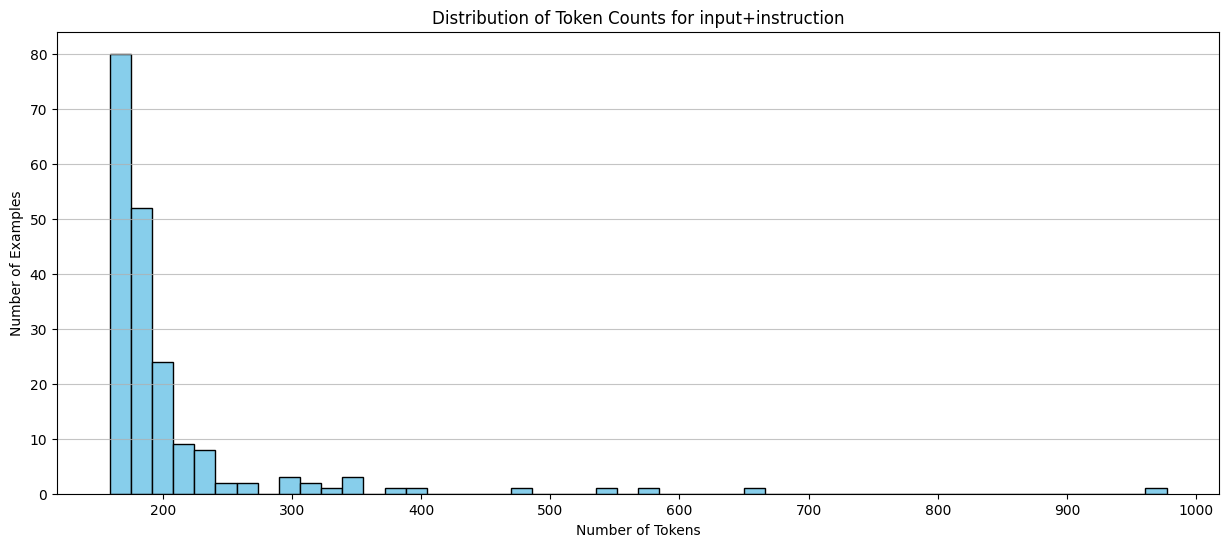

In [8]:
# function to tokenize with options for padding and max_length
def generate_and_tokenize_prompt(prompt, padding, max_length):
    return tokenizer(formatting_func(prompt), padding=padding, truncation=True, max_length=max_length)

# map this function to the dataset without padding or max_length for plotting
tokenized_train_dataset_for_plotting = train_dataset["train"].map(
    generate_and_tokenize_prompt, 
    fn_kwargs={'padding': False, 'max_length': None}
)

# calculate the token lengths
token_lengths = [len(input_ids) for input_ids in tokenized_train_dataset_for_plotting['input_ids']]

# plot
plt.figure(figsize=(15, 6))
plt.hist(token_lengths, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Token Counts for input+instruction')
plt.xlabel('Number of Tokens')
plt.ylabel('Number of Examples')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [9]:
# max context size of Llama 2 by default = 4096, we are keeping it to 1024.
# not filterting out any rows because largers examples are beneficial

tokenized_train_dataset = train_dataset["train"].map(
    generate_and_tokenize_prompt, 
    fn_kwargs={'padding': "max_length", 'max_length': 1024} #max length and apply padding
)

tokenized_validate_dataset = train_dataset["test"].map(
    generate_and_tokenize_prompt, 
    fn_kwargs={'padding': "max_length", 'max_length': 1024} #max length and apply padding
)

Map:   0%|          | 0/193 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

In [10]:
tokenized_train_dataset

Dataset({
    features: ['id', 'output', 'input', 'input_ids', 'attention_mask'],
    num_rows: 193
})

#### Enable Gradient Checkpointing
If you are training a large language model and find that you are running out of memory (OOM errors), enabling gradient checkpointing can help fit the training process within the available memory limits. However, you should be prepared for each epoch to take longer due to the need for recomputation because it doesn't stores all intermediate activations in forward pass but during the backward pass on the fly

In [11]:
model.gradient_checkpointing_enable()

#### PEFT Configuration

Setting up a configuration for using PEFT (Parameter Efficient Finetuning), specifically with an adaptation called LoRA (Low-Rank Adaptation). Used to efficiently finetune llms by adding trainable parameters that influence the model's behavior in a more controlled and resource efficient manner compared to finetuning all parameters.

PEFT is a general approach that significantly reduce memory and compute requirements and helps prevent overfitting when data is limited

LoRA is a specific technique under the umbrella of PEFT where instead of finetuning all parameters of a model, you introduce and train lowrank matrices that adapt the pretrained weights. This adaptation is mathematically designed to capture significant changes with fewer parameters

Great tutorial to understand LoRa and QLoRa: https://www.youtube.com/watch?v=t1caDsMzWBk

In [12]:
model.train() # the model must be in training mode before LoRA is applied to ensure all training-specific behaviors are activated
def create_peft_config(model):
    peft_config = LoraConfig(
        task_type=TaskType.CAUSAL_LM, # the type of task for which the model is being adapted: predicting the next word given the previous context
        inference_mode=False, # inference or training
        r=256, # the rank of the adaptation matrices. A lower rank means fewer parameters are added
        lora_alpha=512, # the extent to which the LoRA parameters influence the original model weights
        lora_dropout=0.05, # dropout rate applied to the LoRA parameters, which can help prevent overfitting during training
        target_modules=[ # list of module names within the model where LoRA adaptations are to be applied
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ]
    )
    model = get_peft_model(model, peft_config)
    model.print_trainable_parameters()
    return model, peft_config
try:
    # create peft config
    model, lora_config = create_peft_config(model)
except:
    model, lora_config = create_peft_config(model)

trainable params: 1,010,892,800 || all params: 14,026,757,120 || trainable%: 7.20688888637433


## Training Setup and Performance Profiling
focuses on efficient resource management and the ability to analyze model behavior during finetuning

In [13]:
enable_profiler = False
output_dir = "tmp/llama-output"

config = {
    'lora_config': lora_config,
    'learning_rate': 2.5e-5,
    'num_train_epochs': 2,
    'gradient_accumulation_steps': 1, # steps to accumulate gradients before performing a backward/update pass, set to 1: no accumulation
    'per_device_train_batch_size': 1, # batch size per device, set to 1
    'gradient_checkpointing': True, # gradient checkpointing to reduce memory usage at the cost of additional computation
}

# Set up profiler
if enable_profiler: # whether profiling should be activated to monitor performance and resource usage during training
    # wait: # of steps to skip before starting profiling
    # warmup: steps used to ramp up the profiler
    # active: steps during which profiling is active
    # repeat: how many times to repeat this profiling cycle

    wait, warmup, active, repeat = 1, 1, 2, 1
    total_steps = (wait + warmup + active) * (1 + repeat)
    schedule =  torch.profiler.schedule(wait=wait, warmup=warmup, active=active, repeat=repeat)
    profiler = torch.profiler.profile(
        schedule=schedule,
        on_trace_ready=torch.profiler.tensorboard_trace_handler(f"{output_dir}/logs/tensorboard"),  # a handler for saving profiler traces
        record_shapes=True,
        profile_memory=True,
        with_stack=True)
    
    class ProfilerCallback(TrainerCallback):
        def __init__(self, profiler):
            self.profiler = profiler
            
        def on_step_end(self, *args, **kwargs):
            self.profiler.step()

    profiler_callback = ProfilerCallback(profiler) # to trigger the profiler’s step function at the end of each training step
else:
    profiler = nullcontext()

## Configuring Training Parameters and Initiating Model Training


In [14]:
# Define training args
training_args = TrainingArguments(
    output_dir=output_dir,
    overwrite_output_dir=True,
    fp16=True,  # Use BF16 if available (enables mixed precision training, using FP16 (or BF16 if available on certain hardware like newer TPUs or GPUs) to reduce memory usage and possibly increase training speed)
    # logging strategies
    logging_dir=f"{output_dir}/logs",
    logging_strategy="steps", # how often to log information
    logging_steps=10, # number of steps between each log
    save_strategy="no", # how often to save the model. It's set to "no", indicating that saving is disabled
    evaluation_strategy="steps", # how often to run evaluation during training
    eval_steps=10, # number of steps between each evaluation.
    optim="adamw_torch_fused", # specifies the optimizer, here using "adamw_torch_fused" which is an optimized version of AdamW
    max_steps=total_steps if enable_profiler else -1, # sets the maximum number of training steps. It uses the total steps calculated for the profiler if profiling is enabled, otherwise, it's set to -1, which generally means training will continue until another stopping condition is met
    **{k:v for k,v in config.items() if k != 'lora_config'} # pass params from config expect lora-config
)

with profiler: # ensures that the profiler is active during the execution block if enabled
    # Create Trainer instance
    trainer = Trainer(
        model=model, # model to be trained
        args=training_args, #  training arguments configured earlier
        train_dataset=tokenized_train_dataset,
        eval_dataset= tokenized_validate_dataset,
        data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False), # mlm=False indicates that it's not using masked language modeling
        callbacks=[profiler_callback] if enable_profiler else [], # a list of callbacks to be used during training. If profiling is enabled, the profiler_callback is included, which will manage step-wise profiling
    )
    # Start training
    trainer.train() # starts the training process according to the specified arguments and setup.

    

Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


wandb: Currently logged in as: parisasuchdev (belief-detection). Use `wandb login --relogin` to force relogin


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/users/p/s/psuchdev/miniconda3/envs/llama_env/lib/python3.9/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
10,1.450600,0.669668
20,0.475600,0.609318
30,0.542500,0.586384
40,0.481200,0.579665
50,0.624100,0.572998
60,0.632000,0.568783
70,0.709200,0.567626
80,0.579200,0.565834
90,0.640800,0.566430
100,0.429500,0.566597


## Wrap-up

In [ ]:
# merge the weights, otherwise it will only save as lora weights, which llama.cpp does not support atm
model = model.merge_and_unload()
# save the model
model.save_pretrained("../models/13Bf_finetuned1.0")
tokenizer.save_pretrained("../models/13Bf_finetuned1.0")

('../models/13Bf_finetuned1.0/tokenizer_config.json',
 '../models/13Bf_finetuned1.0/special_tokens_map.json',
 '../models/13Bf_finetuned1.0/tokenizer.model',
 '../models/13Bf_finetuned1.0/added_tokens.json')

In [ ]:
# Evaluate the new model
eval_prompt = f"""<<SYS>>{sys_prompt}<</SYS>>

[INST] Text: {tokenized_validate_dataset[2]['input']}[/INST]
"""

model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(tokenizer.decode(model.generate(**model_input, max_new_tokens=1000)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<<SYS>>
Pretend you are a philosopher analyzing comments to determine if they express a belief. Define 'belief' as the mental attitude where something is regarded as true, without needing active reflection or evidence.
For each statement, ask:
1. Does this imply the subject regards something as true?
2. Is there an implicit acceptance of truth?
Classify as 'belief' if either condition is met, otherwise as 'non-belief'. Make sure to return results as JSON objects with the original statement and classification.
<</SYS>>

[INST] Text: he loaded his car up with petrol
Make sure to return results as JSON objects with the original statement and classification
[/INST]
Non-belief.

There is no implicit acceptance of truth, as the statement describes an action (loading a car with petrol) rather than expressing a belief.


In [ ]:
instance = tokenized_validate_dataset[2]
eval_prompt = f"""<<SYS>>{sys_prompt}<</SYS>>

[INST]Text: {instance['input']}[/INST]
"""
model.eval() # put the model in evaluation mode


# tokenize the prompt
model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

# generate a response without gradient calculations
with torch.no_grad():
    output = model.generate(**model_input, max_new_tokens=1000)[0]
    decoded_output = tokenizer.decode(output, skip_special_tokens=True)
 
    classification = decoded_output.split('Output: ')[1].split('\n')[0].strip() # the classification and justification from the output
    justification = decoded_output.split('Justification: ')[1].strip() # the format "Output: [classification]\nJustification: [justification]"

    # Create a JSON object with the original text, classification, and justification
    result = {
        "original_text": instance['input'],
        "classification": classification,
        "justification": justification
    }
    print(json.dumps(result, indent=4))


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


{
    "original_text": "he loaded his car up with petrol",
    "classification": "non-belief",
    "justification": "The statement does not imply the subject regards something as true, and there is no implicit acceptance of truth. The statement simply describes an action (loading a car with petrol) without expressing any belief or acceptance of truth."
}
